In [2]:
import pandas as pd

df = pd.read_csv('../../data_모델용/1cha_상림_VIP_merge_data.csv')

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# 0. 데이터 정렬 (중요: 회원별, 월별 순서가 맞아야 rolling이 정확합니다)
df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 이동 기울기(Rolling Slope) 계산 함수
# -------------------------------------------------------
def calc_slope(y):
    # 데이터가 2개 미만이면 기울기를 구할 수 없음
    if len(y) < 2 or np.sum(y) == 0:
        return 0.0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# 최근 3개월(window=3)의 데이터를 사용하여 기울기 산출
# min_periods=2: 데이터가 2개만 쌓여도 기울기 계산 시작
group = df.groupby('발급회원번호')

df['Slope_Spend'] = group['이용금액_신용_B0M'].rolling(window=3, min_periods=2).apply(calc_slope).reset_index(level=0, drop=True)
df['Slope_Balance'] = group['잔액_B0M'].rolling(window=3, min_periods=2).apply(calc_slope).reset_index(level=0, drop=True)
df['Slope_Count'] = group['이용건수_신용_B0M'].rolling(window=3, min_periods=2).apply(calc_slope).reset_index(level=0, drop=True)

# 결측치(첫 달 등)는 0으로 채움
df[['Slope_Spend', 'Slope_Balance', 'Slope_Count']] = df[['Slope_Spend', 'Slope_Balance', 'Slope_Count']].fillna(0)

# -------------------------------------------------------
# 2. 기울기를 '이탈 점수'로 변환 (모든 행에 대해 계산)
# -------------------------------------------------------
scaler = MinMaxScaler()

def convert_slopes_to_scores(dataframe):
    # 음수(감소)인 경우만 추출하여 양수로 변환 (가장 많이 줄어든 게 가장 큰 값)
    # 7월부터 12월까지 모든 행의 기울기를 한꺼번에 스케일링하여 상대적 위치 파악
    temp_scores = {}
    for col in ['Slope_Spend', 'Slope_Balance', 'Slope_Count']:
        neg_val = dataframe[col].apply(lambda x: -x if x < 0 else 0)
        temp_scores[col] = scaler.fit_transform(neg_val.values.reshape(-1, 1)).flatten()
    return temp_scores

# 정규화된 점수 계산 (0.0 ~ 1.0)
norm_scores = convert_slopes_to_scores(df)

# -------------------------------------------------------
# 3. 가중치 적용 및 최종 점수(Churn_Score) 산출
# -------------------------------------------------------
W_SPEND, W_BALANCE, W_COUNT, W_RISK = 40, 30, 20, 10

# 리스크 점수 (연체나 거절이 있으면 1점, 없으면 0점 -> 나중에 가중치 10 곱함)
df['Risk_Flag'] = np.where(
    (df.get('연체잔액_B0M', 0) > 0) | (df.get('승인거절건수_B0M', 0) > 0),
    1, 0
)

# 최종 스코어 합산
df['Churn_Score'] = (
    (norm_scores['Slope_Spend'] * W_SPEND) +
    (norm_scores['Slope_Balance'] * W_BALANCE) +
    (norm_scores['Slope_Count'] * W_COUNT) +
    (df['Risk_Flag'] * W_RISK)
)

df['Churn_Score'] = df['Churn_Score'].round(1)

# -------------------------------------------------------
# 4. 결과 확인 (최신 월인 12월 데이터만 보기)
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

print(f"\n[{target_month} 기준 이탈 위험 점수 상위 10명]")
cols_view = ['발급회원번호', '기준년월', 'Slope_Spend', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))


[201812 기준 이탈 위험 점수 상위 10명]
            발급회원번호    기준년월  Slope_Spend  Churn_Score
57332  SYN_2356750  201812    -706442.0         19.1
55453  SYN_1798036  201812    -487893.5         18.2
56606  SYN_2142158  201812    -556219.5         17.1
56827  SYN_2211883  201812    -371647.0         15.9
52840  SYN_1001432  201812    -524452.0         15.7
51459   SYN_602347  201812    -275039.5         15.6
52436   SYN_888309  201812    -448843.5         15.5
55724  SYN_1880379  201812    -633319.0         15.4
51061   SYN_482224  201812    -452138.0         15.4
57249  SYN_2331135  201812    -403738.0         15.3


In [4]:
# 1. 확인하고 싶은 발급회원번호 설정 (실제 데이터에 있는 번호를 넣으세요)
target_id = df['발급회원번호'].iloc[9765]  # 예시로 첫 번째 회원의 ID를 가져옵니다.

# 2. 해당 회원의 데이터만 추출하여 주요 컬럼 확인
# 새로 만든 컬럼들 + 기준이 되는 컬럼들을 함께 봅니다.
view_cols = [
    '기준년월',
    '이용금액_신용_B0M', 'Slope_Spend',   # 실제 소비량과 그 기울기
    '잔액_B0M', 'Slope_Balance',        # 잔액과 그 기울기
    'Risk_Flag',                       # 리스크 여부
    'Churn_Score'                      # 최종 이탈 위험 점수
]

customer_history = df[df['발급회원번호'] == target_id][view_cols].sort_values('기준년월')

print(f"🔎 [회원번호: {target_id}] 의 6개월간 이탈 징후 변화")
print("-" * 100)
print(customer_history)
print("-" * 100)

# 3. (팁) 점수가 가장 많이 변한 달 찾기
diff = customer_history['Churn_Score'].max() - customer_history['Churn_Score'].min()
print(f"💡 해당 고객의 6개월간 점수 변동폭: {diff:.1f}점")

🔎 [회원번호: SYN_1457477] 의 6개월간 이탈 징후 변화
----------------------------------------------------------------------------------------------------
         기준년월  이용금액_신용_B0M  Slope_Spend  잔액_B0M  Slope_Balance  Risk_Flag  \
4841   201807      1049413          0.0  478046            0.0          0   
14735  201808      1123536      74123.0  579338       101292.0          0   
24629  201809       843987    -102713.0  615551        68752.5          0   
34523  201810      1152193      14328.5  517074       -31132.0          0   
44417  201811      1174724     165368.5  484710       -65420.5          0   
54311  201812      1035006     -58593.5  487305       -14884.5          0   

       Churn_Score  
4841           0.0  
14735          1.7  
24629          2.9  
34523          0.1  
44417          0.3  
54311          1.7  
----------------------------------------------------------------------------------------------------
💡 해당 고객의 6개월간 점수 변동폭: 2.9점


In [5]:
df.head()

,기준년월,발급회원번호,VIP등급코드,입회일자_신용,입회경과개월수_신용,탈회횟수_누적,최종탈회후경과월,유효카드수_신용,이용카드수_신용,_2순위카드이용건수,...,변동률_할부평잔,혜택수혜율_R3M,혜택수혜율_B0M,이용금액_신용_B0M,이용건수_신용_B0M,Slope_Spend,Slope_Balance,Slope_Count,Churn_Score,Risk_Flag
366,201807,SYN_100022,7,20150401,40,0,0,1,1,0,...,0.0,1.029737,0.0,480339,19,0.0,0.0,0.0,0.0,0
10260,201808,SYN_100022,7,20150401,41,0,0,1,1,0,...,0.0,0.000000,0.0,521058,14,40719.0,882129.0,-5.0,4.3,0
20154,201809,SYN_100022,7,20150401,42,0,0,2,1,0,...,0.0,0.000000,0.0,468354,17,-5992.5,441733.0,-1.0,1.0,0
30048,201810,SYN_100022,7,20150401,43,0,0,1,1,0,...,0.0,0.000000,0.0,464798,15,-28130.0,182261.0,0.5,0.6,0
39942,201811,SYN_100022,7,20150401,44,0,0,2,1,0,...,0.0,0.000000,0.0,563454,22,47550.0,350593.0,2.5,0.0,0



[클러스터별 평균 특성 확인]
            Churn_Score    Slope_Spend
Cluster_ID                            
0              1.222487   -4883.247400
1              8.397764 -208648.359600
2              0.698679  201868.839301


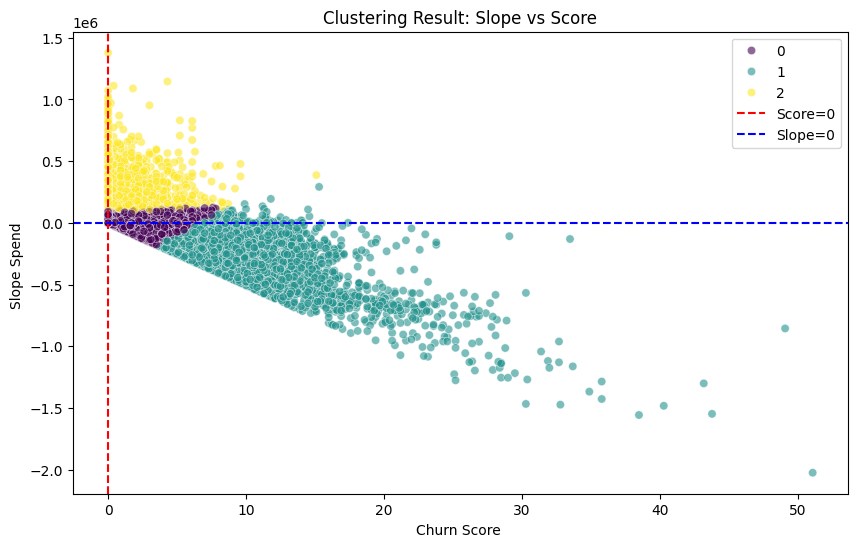

------------------------------
[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0            48276  81.32
1             6396  10.77
2             4692   7.90
------------------------------


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 각자 컴퓨터에서 df 로드하고
# df_final 에 Churn_Score 만드는 코드까지 작성한 후에 아래 코드 실행!

# -------------------------------------------------------
# 1. 클러스터링에 사용할 핵심 변수 선택 (수정됨)
# -------------------------------------------------------
# 기존 코드에서는 'Churn_Score'만 사용했으나, 주석 내용대로 'Slope_Spend'도 포함하여
# 이탈 점수와 소비 감소 추세 두 가지 기준으로 군집화를 진행합니다.
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비
X_cluster = df[cluster_cols].copy()

# -------------------------------------------------------
# 2. 데이터 스케일링 (필수)
# -------------------------------------------------------
# 두 변수의 단위가 다르므로(점수 vs 금액) 정규화(StandardScaler)를 수행합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# -------------------------------------------------------
# 3. K-Means 클러스터링 (K=3)
# -------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (통계)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df.groupby('Cluster_ID')[cluster_cols].mean())

# -------------------------------------------------------
# 5. 시각화 (수정됨: X축, Y축 설정)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# X축: 이탈 점수 (Churn_Score)
# Y축: 소비 기울기 (Slope_Spend) - 소비가 급격히 줄어드는 패턴 확인
sns.scatterplot(
    data=df,
    x='Churn_Score',
    y='Slope_Spend',  # Y축에 소비 기울기 추가
    hue='Cluster_ID',
    palette='viridis',
    alpha=0.6
)

plt.title('Clustering Result: Slope vs Score')
plt.xlabel('Churn Score ')
plt.ylabel('Slope Spend ')

# 기준선 추가 (보기 편하게)
plt.axvline(x=0, color='r', linestyle='--', label='Score=0')
plt.axhline(y=0, color='b', linestyle='--', label='Slope=0') # 소비 증감 0선 추가
plt.legend()
plt.show()

# -------------------------------------------------------
# 6. 클러스터 비중 확인
# -------------------------------------------------------
# 전체 인원수 및 비율 계산
cluster_counts = df['Cluster_ID'].value_counts().sort_index()
cluster_ratios = df['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

print("-" * 30)
print("[클러스터별 분포 현황]")
df_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2)
})
print(df_summary)
print("-" * 30)

# (참고) 클러스터링 결과에 따라 위험군(Cluster ID)이 바뀔 수 있으니
# 위 [클러스터별 평균 특성 확인] 표를 보고 가장 점수가 높은 그룹을 확인해야 합니다.

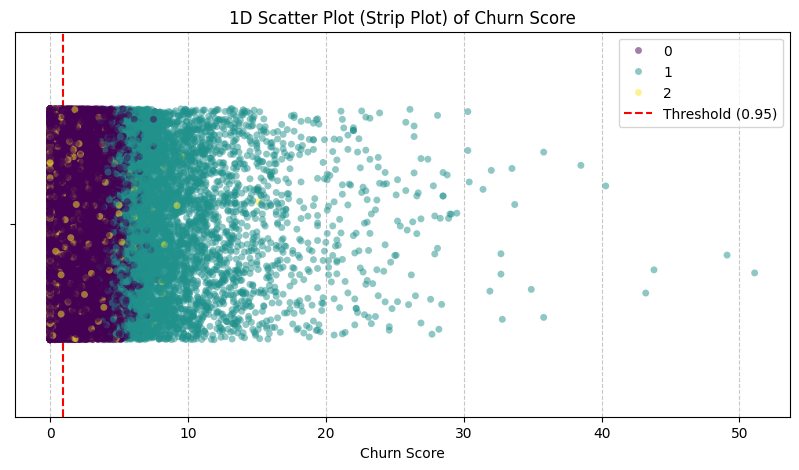

In [8]:
# 1차원 데이터 시각화 (Strip Plot)
import seaborn as sns
import matplotlib.pyplot as plt

# 주의: 이 코드는 위쪽 셀에서 'Cluster_ID'가 생성된 후에 실행해야 합니다.

plt.figure(figsize=(10, 5))

# y축 없이 x축(Churn_Score)만 사용하여 분포 확인
# jitter=0.3: 점들이 겹치지 않도록 위아래로 흩뿌림
sns.stripplot(
    data=df,
    x='Churn_Score',
    hue='Cluster_ID',   # 클러스터별 색상 구분
    palette='viridis',
    alpha=0.5,
    jitter=0.3
)

plt.title('1D Scatter Plot (Strip Plot) of Churn Score')
plt.xlabel('Churn Score')

# 기준선 표시 (이전 분석의 임계값 참고)
plt.axvline(x=0.95, color='red', linestyle='--', label='Threshold (0.95)')

plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# 1. 고위험군(Cluster 2)인지 아닌지 딱 두 그룹으로 라벨링 (이진 분류 준비)
# Cluster 2면 1(High Risk), 아니면 0(Others)
df['is_high_risk'] = (df['Cluster_ID'] == 2).astype(int)

# 2. 의사결정나무 모델로 '경계선' 찾기
# (깊이를 1로 설정하여 가장 핵심적인 첫 번째 질문을 찾습니다)
tree_model = DecisionTreeClassifier(max_depth=1)
tree_model.fit(df[['Churn_Score']], df['is_high_risk'])

# 3. 기준 점수 추출
threshold = tree_model.tree_.threshold[0]

print(f"🔍 [분석 결과] Cluster 2를 나누는 Churn_Score 기준 점수: 약 {threshold:.2f}점")
print("-" * 50)

# 4. 통계적으로 확인 (최소/최대값 비교)
cluster_stats = df.groupby('Cluster_ID')['Churn_Score'].agg(['min', 'max', 'mean'])
print("[클러스터별 Churn_Score 통계 수치]")
print(cluster_stats)

print("-" * 50)
print(f"💡 즉, Churn_Score가 {threshold:.2f}점을 넘어가면 'Cluster 2(고위험군)'에 속할 확률이 매우 높습니다.")

🔍 [분석 결과] Cluster 2를 나누는 Churn_Score 기준 점수: 약 0.95점
--------------------------------------------------
[클러스터별 Churn_Score 통계 수치]
            min   max      mean
Cluster_ID                     
0           0.0   7.8  1.222487
1           3.6  51.1  8.397764
2           0.0  15.1  0.698679
--------------------------------------------------
💡 즉, Churn_Score가 0.95점을 넘어가면 'Cluster 2(고위험군)'에 속할 확률이 매우 높습니다.


In [ ]:
import numpy as np

# 방법 1: np.where 활용 (가장 직관적이고 빠름)
# 조건, 참일 때 값, 거짓일 때 값 순서입니다.
df['churn_target'] = np.where(df['Churn_Score'] >= 0.95, 1, 0)

# 방법 2: 불리언 변환 활용 (코드가 간결함)
# df['churn_target'] = (df['Churn_Score'] >= 10.35).astype(int)

# -------------------------------------------------------
# 결과 확인
# -------------------------------------------------------
print("[타겟 변수 분포 확인]")
print(df['churn_target'].value_counts())

print("\n[상위 5개 데이터 확인]")
print(df[['발급회원번호', 'Churn_Score', 'churn_target']].head())

[타겟 변수 분포 확인]
churn_target
0    31254
1    28110
Name: count, dtype: int64

[상위 5개 데이터 확인]
           발급회원번호  Churn_Score  churn_target
366    SYN_100022          0.0             0
10260  SYN_100022          4.3             1
20154  SYN_100022          1.0             1
30048  SYN_100022          0.6             0
39942  SYN_100022          0.0             0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59364 entries, 366 to 52831
Data columns (total 83 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   기준년월                59364 non-null  int64  
 1   발급회원번호              59364 non-null  object 
 2   VIP등급코드             59364 non-null  int64  
 3   입회일자_신용             59364 non-null  int64  
 4   입회경과개월수_신용          59364 non-null  int64  
 5   탈회횟수_누적             59364 non-null  int64  
 6   최종탈회후경과월            59364 non-null  int64  
 7   유효카드수_신용            59364 non-null  int64  
 8   이용카드수_신용            59364 non-null  int64  
 9   _2순위카드이용건수          59364 non-null  int64  
 10  최종유효년월_신용_이용가능      57752 non-null  float64
 11  최종유효년월_신용_이용        55831 non-null  float64
 12  최종카드발급일자            59253 non-null  float64
 13  최초한도금액              59364 non-null  int64  
 14  카드이용한도금액            59364 non-null  int64  
 15  CA한도금액              59364 non-null  int64  
 16  CA이자율_할

In [ ]:

# ============================================================================
# 핵심 1: 불필요한 컬럼 정의
# ============================================================================
target_col = 'churn_target'  # 정답지
drop_cols = ['churn_target', 'Churn_Score','Slope_Spend','Slope_Balance','Slope_Count', '발급회원번호', '기준년월',
    '이용금액_신용_B0M',  '이용건수_신용_B0M','잔액_B0M','Risk_Flag','교통_주유이용금액',
    '정상입금원금_B5M',
    '할부금액_무이자_6M_R12M',
    '유효카드수_신용',
    '이용금액_납부',
    '이용금액_신용_R12M',
    'RP건수_B0M',
    '잔액_할부_B0M',
    '이용금액_할부_무이자_R12M',
    '최종이용일자_카드론',
    '연체입금원금_B0M',
    '연체입금원금_B2M',
    '이용카드수_신용',
    '정상입금원금_B0M',
    '납부_기타이용금액',
    '잔액_B0M',
    '할부금액_6M_R12M',
    '납부_통신비이용금액',
    '이용금액_교통']

# ============================================================================
# 핵심 2: 월별로 데이터 쪼개기 (Time Split)
# ============================================================================
# 1) 학습 데이터 (7, 8, 9, 10월)
train_df = df[df['기준년월'].isin([201807, 201808, 201809, 201810])]

# 2) 검증 데이터 (11월) - 모델 채점용
valid_df = df[df['기준년월'] == 201811]

# 3) 실전 예측 데이터 (12월) - 정답(Target)이 없는 미래 데이터
predict_df = df[df['기준년월'] == 201812]

# ============================================================================
# 핵심 3: X(문제), y(정답) 나누기
# ============================================================================
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_predict = predict_df.drop(columns=drop_cols)
predict_ids = predict_df['발급회원번호'] # 결과 매칭용 ID 킵

# 문자열 -> category 변환 (LightGBM 최적화)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        X_predict[col] = X_predict[col].astype('category')

# ============================================================================
# 핵심 4: 모델 학습
# ============================================================================
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# ============================================================================
# 핵심 5: 12월 고객에 대한 이탈 확률 예측 및 결과 저장
# ============================================================================
pred_prob = model.predict_proba(X_predict)[:, 1]

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

# # 드라이브에 결과 저장 (CSV)
# final_result.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f"예측 결과가 다음 경로에 저장되었습니다: {output_path}")
# print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.59418
            발급회원번호    이탈예측확률
49722    SYN_72058  0.989274
57053  SYN_2270812  0.988494
56518  SYN_2117942  0.988178
57332  SYN_2356750  0.987999
54110  SYN_1402725  0.987448
57433  SYN_2387810  0.987448
57966  SYN_2545512  0.987440
58185  SYN_2613707  0.987432
52539   SYN_917489  0.987399
54645  SYN_1560704  0.987349


In [ ]:
pred_valid = model.predict(X_valid)
print("검증(11월) 정확도:", accuracy_score(y_valid, pred_valid))

검증(11월) 정확도: 0.6393774004447139
